# Self-Organized Map (SOM)

## Pablo Valdunciel Sánchez 
## 1st December, 2019

## Imports

In [1]:
import numpy as np 
import random
import math
from keras.datasets import mnist
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import  accuracy_score

from scipy.spatial.distance import euclidean
from scipy.stats import mode

Using TensorFlow backend.


# Data preparation

In [13]:
# IRIS
dataset = load_iris()
iris_X = dataset["data"]
iris_X = MinMaxScaler().fit_transform(iris_X)
iris_Y = dataset["target"]
iris_x_train, iris_x_test, iris_y_train, iris_y_test = train_test_split(iris_X, iris_Y, test_size=0.33, random_state=42, stratify=iris_Y)

# MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_train = MinMaxScaler().fit_transform(x_train)
x_test = MinMaxScaler().fit_transform(x_test)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(60000, 784) (10000, 784) (60000,) (10000,)


## SOM class

In [3]:
class SOM: 
    """Self-Organized Map class"""
    
    def __init__(self, n, rows, cols, max_iteration=1000, initial_alpha=1, 
                 final_alpha=0.001, initial_radius=None, final_radius=0, verbose=False, print_step=1):
        """Constructor"""
        self.__initial_alpha = initial_alpha
        self.__final_alpha = final_alpha
        self.__initial_radius = math.ceil(min(rows,cols)/2) if not initial_radius else initial_radius
        self.__final_radius = final_radius
        self.__iteration = 0
        self.__max_iteration = max_iteration         
        self.__codebook =  np.random.rand(rows,cols,n)
        self.__verbose = verbose
        self.__print_step = print_step
        
        print(self)
        
    # ---------------------------------------------- Properties ---------------------------------------------# 
    @property
    def rows(self):
        return self.__codebook.shape[0]
    
    @property
    def cols(self):
        return self.__codebook.shape[1]   
   
    @property
    def __n(self):
        return self.__codebook.shape[2]
    
    @property   
    def __alpha(self): 
        return self.__initial_alpha+(self.__final_alpha-self.__initial_alpha)*(self.__iteration/self.__max_iteration)

    @property
    def __radius(self):
        return max(self.__final_radius, self.__initial_radius - self.__iteration)
          
    
    # --------------------------------------------- Methods -----------------------------------------------------#
    @staticmethod
    def print_mapping(neuron_labels):
        """Plots the a SOM's labeling"""
        rows = neuron_labels.shape[0]
        cols = neuron_labels.shape[1]
        
        fig, ax = plt.subplots()        
        im = ax.imshow(neuron_labels)

        # Show all ticks 
        ax.set_xticks(np.arange(cols))
        ax.set_yticks(np.arange(rows))
        
        # Label the ticks with the row/col number
        ax.set_xticklabels(range(cols))
        ax.set_yticklabels(range(rows))
        
        # Adjust axis
        ax.set_xticks(np.arange(cols+1)-.5, minor=True)
        ax.set_yticks(np.arange(rows+1)-.5, minor=True)
        
        # Add the label to each position
        for i in range(rows):
            for j in range(cols):
                if neuron_labels[i][j] != None:
                    text = ax.text(j, i, neuron_labels[i, j],
                               ha="center", va="center", color="w")

        ax.set_title("SOM mapping")
        fig.tight_layout()
        plt.show()
        
    def __str__(self):
        """Gets a string representation of the SOM object"""
        return "SOM (n={}, rows={}, cols={}, max_iteration={}, initial_alpha={}, final_alpha={}, initial_radius={}, final_radius={}, verbose={}".format(self.__n, self.rows, self.cols, self.__max_iteration, self.__initial_alpha, self.__final_alpha, self.__initial_radius, self.__final_radius, self.__verbose)
        
        
    def __get_bmu(self, xv):
        """Get the closest neuron to an instance"""
        min_distance = np.finfo(np.float128).max
        bmu = None

        for i in range(self.rows):
            for j in range(self.cols):
                distance = self.get_distance_to_neuron(i,j,xv)
                if distance < min_distance:
                    min_distance = distance 
                    bmu = np.array([i,j])
        return bmu 
        
        
    def __get_neighbors_matrix(self, ui, uj):
        """Obtain a matrix indicating which neurons are within the neighbourhood 
           of a given neuron"""
        neighbors = np.zeros((self.rows, self.cols, self.__n), dtype=float)
        upper_i = (ui+self.__radius)
        lower_i = (ui-self.__radius) 
        upper_j = (uj+self.__radius) 
        lower_j = (uj-self.__radius)
        for i in range(lower_i, upper_i+1):
            for j in range(lower_j, upper_j+1):       
                neighbors[i%self.rows][j%self.cols] = 1.0  
                
        return neighbors
   
        
    def fit(self, D):
        """ Fit the SOM with a given data set D"""
        self.__P = D.shape[0]
    
        while self.__iteration < self.__max_iteration:  
            
            if self.__verbose:
                    print("\n\nEpoch {}, radius = {}, alpha = {}".format(self.__iteration, self.__radius, self.__alpha))
                    
            for v in range(self.__P):              
                if self.__verbose and (v%self.__print_step == 0):
                    print(v, end = '  ')
                    
                i = np.random.randint(low=0, high=self.__P)
                xv = D[i]                    
                bmu = self.__get_bmu(xv)  # Calculate the BMU
                neighbors = self.__get_neighbors_matrix(bmu[0], bmu[1])  # Get BMU neighbors

                # Modify weigths of the BMU's neighbors  
                self.__codebook = self.__codebook + self.__alpha*(np.subtract((neighbors*xv),(neighbors*self.__codebook)))

            # Increase the iteration (affects the alpha and the radius)
            self.__iteration += 1 
            
    def get_neuron_weights(self, i, j):
        """Get a given neuron's weights vector"""
        if i >= self.rows or j >= self.cols:
             raise IndexError('list index out of range')
                
        return self.__codebook[i,j,:]
         
    
    def get_distance_to_neuron(self, i, j, xv):
        """Obtain the distance between an instance and a certain neuron"""
        return euclidean(self.__codebook[i,j,:], xv)
    
    def closest_neuron(self, D):
        """Obtain the closest neuron to each instance of a given data set D"""
        closest_neurons = np.zeros((D.shape[0],2), dtype=int)
        
        for v in range(D.shape[0]):
            bmu = self.__get_bmu(D[v])
            closest_neurons[v] = bmu 
            
        return closest_neurons
    
    
    def mode_labeling(self, X, Y):
        """"""
        neurons = self.closest_neuron(X)
        mode_labels = np.empty((self.rows, self.cols), dtype=float)

        for row in range(self.rows):
            for col in range(self.cols):
                neuron_labels = []        
                for i in range(neurons.shape[0]):
                    if (neurons[i][0] == row) and (neurons[i][1] == col):
                        neuron_labels.append(Y[i])

                if len(neuron_labels) > 0:       
                    mode_labels[row][col] =  mode(neuron_labels)[0]
                else:
                    mode_labels[row][col] = None
        
        return mode_labels 
    
    
    def neuron_labeling(self, X, Y):
        """Calculates the the closest intance to each neuron and assigns its label to that neuron"""
        neuron_labels = np.empty((self.rows, self.cols), dtype=float)

        for row in range(self.rows):
            for col in range(self.cols):
                closest_label = None         
                distances_to_neuron = np.array(list(map(lambda x : self.get_distance_to_neuron(row, col, x), X)))
                closest_label = Y[np.argmin(distances_to_neuron, axis=0)]
                neuron_labels[row, col] = closest_label 
        
        return neuron_labels    

###  Iris data set

In [4]:
MAP_ROWS = 3
MAP_COLS = 5
ITERATIONS = 150

som = SOM(iris_x_train.shape[1], MAP_ROWS, MAP_COLS, max_iteration= ITERATIONS, initial_alpha=1)
som.fit(iris_x_train)

SOM (n=4, rows=3, cols=5, max_iteration=150, initial_alpha=1, final_alpha=0.001, initial_radius=2, final_radius=0, verbose=False


In [5]:
# Get closest (output) neuron for each test instance
closest_neurons = som.closest_neuron(iris_x_test)

#### MODE classification


--- IRIS ---
Hit rate = 1.0


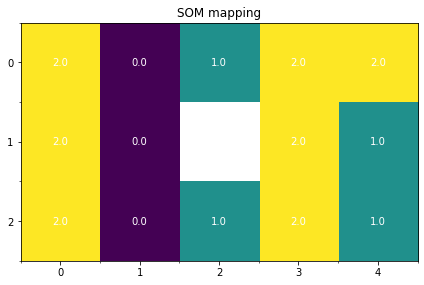

In [6]:
print("\n--- IRIS ---")
# Get neuron labels applying 'mode labeling'
mode_labels = som.mode_labeling(iris_x_test, iris_y_test)

# Predict
prediction = np.empty((closest_neurons.shape[0]), dtype=float)
for i in range(prediction.shape[0]):
    prediction[i] = mode_labels[closest_neurons[i][0]][closest_neurons[i][1]]

# Calculate hit rate 
hit_rate = accuracy_score(prediction, iris_y_test)
print("Hit rate = {}".format(hit_rate))

# Print mapping
SOM.print_mapping(mode_labels)

#### Neuron classification


--- IRIS ---
Hit rate = 1.0


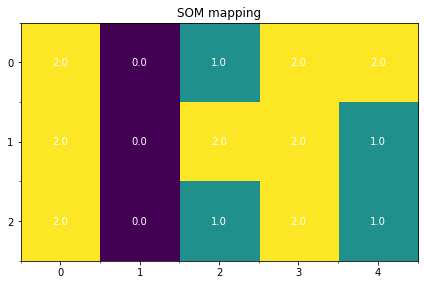

In [7]:
print("\n--- IRIS ---")
# Get neuron labels applying 'neuron labeling'
neuron_labels = som.neuron_labeling(iris_x_test, iris_y_test)

# Predict
prediction = np.empty((closest_neurons.shape[0]), dtype=float)

for i in range(prediction.shape[0]):
    prediction[i] = neuron_labels[closest_neurons[i][0]][closest_neurons[i][1]]

# Calculate hit rate 
hit_rate = accuracy_score(prediction, iris_y_test)
print("Hit rate = {}".format(hit_rate))

# Print mapping 
SOM.print_mapping(neuron_labels)

### Mnist data set 

In [9]:
MAP_ROWS = 8
MAP_COLS = 12
ITERATIONS = 13

som = SOM(x_train.shape[1], MAP_ROWS, MAP_COLS, max_iteration=ITERATIONS, initial_alpha=2, verbose=True, print_step=2000)
som.fit(x_train)

SOM (n=784, rows=8, cols=12, max_iteration=13, initial_alpha=2, final_alpha=0.001, initial_radius=4, final_radius=0, verbose=True


Epoch 0, radius = 4, alpha = 2.0
0  2000  4000  6000  8000  10000  12000  14000  16000  18000  20000  22000  24000  26000  28000  30000  32000  34000  36000  38000  40000  42000  44000  46000  48000  50000  52000  54000  56000  58000  

Epoch 1, radius = 3, alpha = 1.8462307692307691
0  2000  4000  6000  8000  10000  12000  14000  16000  18000  20000  22000  24000  26000  28000  30000  32000  34000  36000  38000  40000  42000  44000  46000  48000  50000  52000  54000  56000  58000  

Epoch 2, radius = 2, alpha = 1.6924615384615385
0  2000  4000  6000  8000  10000  12000  14000  16000  18000  20000  22000  24000  26000  28000  30000  32000  34000  36000  38000  40000  42000  44000  46000  48000  50000  52000  54000  56000  58000  

Epoch 3, radius = 1, alpha = 1.5386923076923076
0  2000  4000  6000  8000  10000  12000  14000  16000  18000  20000  22000  240

In [19]:
# Get closest (output) neuron for each test instance
closest_neurons = som.closest_neuron(x_test)

#### Mode classification


--- MNIST - Mode classification ---
Hit rate = 0.8346


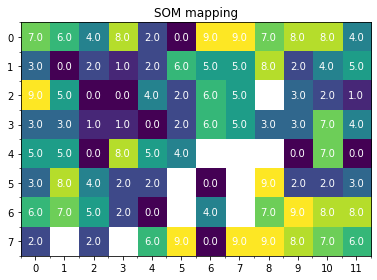

In [20]:
print("\n--- MNIST - Mode classification ---")
# Get neuron labels applying 'neuron labeling'
mode_labels = som.mode_labeling(x_test, y_test)

# Predict
prediction = []
for i in range(closest_neurons.shape[0]):
    prediction.append(mode_labels[closest_neurons[i][0]][closest_neurons[i][1]])

# Calculate hit rate 
hit_rate = accuracy_score(prediction, y_test)
print("Hit rate = {}".format(hit_rate))

# Print mapping
SOM.print_mapping(mode_labels)


--- MNIST - Neuron classification ---
Hit rate = 0.8261


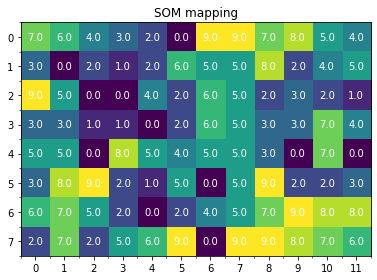

In [21]:
print("\n--- MNIST - Neuron classification ---")
# Get neuron labels applying 'neuron labeling'
neuron_labels = som.neuron_labeling(x_test, y_test)

# Predict
prediction = np.empty((y_test.shape[0]), dtype=float)

for i in range(prediction.shape[0]):
    prediction[i] = neuron_labels[closest_neurons[i][0]][closest_neurons[i][1]]

# Calculate hit rate 
hit_rate = accuracy_score(prediction, y_test)
print("Hit rate = {}".format(hit_rate))

# Print mapping 
SOM.print_mapping(neuron_labels)